#### Imports 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit_aer import Aer
from math import pi,log
from qiskit import *
import time
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf
import numpy as np
# from qiskit import IBMQ
import os
from datetime import datetime
from qiskit.circuit.library import UnitaryGate
import scipy
from scipy.stats import entropy
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#### Running and Saving Details

In [9]:
from datetime import datetime
# Network saving and loading
epoch = 25
runtime_name = datetime.now().strftime("Date-%d%m%y--Hours-%H%M")
runtime_name += "-epoch-{}".format(epoch)
os.mkdir(runtime_name)
backend = Aer.get_backend('qasm_simulator')

#### Get Data

In [10]:
# Subsample to SUBSAMPLE datapoints. This is due to computational cost.
# Chance SUBSAMPLE to what best suits your computer, to make a reasonable training time.
test_images,test_labels = tf.keras.datasets.mnist.load_data()
train_images = test_images[0].reshape(60000,784)
train_labels = test_images[1]
labels = test_images[1]
train_images = train_images/255
k=4
pca = PCA(n_components=k)
pca.fit(train_images)

# Computational cost is high for 60,000 data points. Change 6000 to what your system can handle
SUBSAMPLE = 1000
pca_data = pca.transform(train_images)[:SUBSAMPLE]
train_labels = train_labels[:SUBSAMPLE]
t_pca_data = pca_data.copy()
pca_descaler = [[] for _ in range(k)]

### <font color='green'> Data Transformation

<font color='green'> Changes made: no rotations or squaring before filtering out unused data.

In [11]:
# Data Transformation Section
for i in range(k):
    if pca_data[:,i].min() < 0:
        pca_descaler[i].append(pca_data[:,i].min())
        pca_data[:,i] += np.abs(pca_data[:,i].min())
    else:
        pca_descaler[i].append(pca_data[:,i].min())
        pca_data[:,i] -= pca_data[:,i].min()
    pca_descaler[i].append(pca_data[:,i].max())
    pca_data[:,i] /= pca_data[:,i].max()

#CHANGE
# pca_data_rot= np.sqrt(pca_data)
pca_data_rot= pca_data

valid_labels = None
valid_labels = train_labels==3
valid_labels += train_labels == 6

for col in range(pca_data.shape[1]):
    t_data_mean = pca_data[:,col].mean()
    t_data_std = pca_data[:,col].std()
    valid_upper_bound = pca_data[:,col] < t_data_mean+t_data_std
    valid_lower_bound = pca_data[:,col] > t_data_mean-t_data_std
    valid = np.logical_and(valid_upper_bound,valid_lower_bound)
    pca_data = pca_data[valid]

pca_data_rot3 = pca_data_rot[train_labels==3]
pca_data_rot6 = pca_data_rot[train_labels==6]

#### Utils

In [27]:
# Checkpointing code
def save_variables(var_dict, epoch, number_class):
    with open(f"{runtime_name}/Epoch-{epoch}-Variables-numbers-{number_class}", 'w') as file:
        file.write(str(var_dict))

# Ran_ang returns a random angle
def ran_ang():
    return np.random.rand() * 2 * np.pi


def single_qubit_unitary(circ_ident, qubit_index, values):
    circ_ident.ry(values[0], qubit_index)
    circ_ident.rz(values[1], qubit_index)


def dual_qubit_unitary(circ_ident, qubit_1, qubit_2, values):
    circ_ident.ryy(values[0], qubit_1, qubit_2)
    circ_ident.rzz(values[1], qubit_1, qubit_2)


def controlled_dual_qubit_unitary(circ_ident, control_qubit, act_qubit, values):
    circ_ident.cry(values[0], control_qubit, act_qubit)
    circ_ident.crz(values[1], control_qubit, act_qubit)


def traditional_learning_layer(circ_ident, num_qubits, values, style="Dual", qubit_start=1, qubit_end=5):
    if style == "Dual":
        for qub in np.arange(qubit_start, qubit_end):
            single_qubit_unitary(circ_ident, qub, values[str(qub)])
        for qub in np.arange(qubit_start, qubit_end - 1):
            dual_qubit_unitary(circ_ident, qub, qub + 1, values[str(qub) + "," + str(qub + 1)])
    elif style == "Single":
        for qub in np.arange(qubit_start, qubit_end):
            single_qubit_unitary(circ_ident, qub, values[str(qub)])
    elif style == "Controlled-Dual":
        for qub in np.arange(qubit_start, qubit_end):
            single_qubit_unitary(circ_ident, qub, values[str(qub)])
        for qub in np.arange(qubit_start, qubit_end - 1):
            dual_qubit_unitary(circ_ident, qub, qub + 1, values[str(qub) + "," + str(qub + 1)])
        for qub in np.arange(qubit_start, qubit_end - 1):
            controlled_dual_qubit_unitary(circ_ident, qub, qub + 1, values[str(qub) + "--" + str(qub + 1)])


def swap_test(circ_ident, num_qubits):
    num_swap = num_qubits // 2
    for i in range(num_swap):
        circ_ident.cswap(0, i + 1, i + num_swap + 1)
    circ_ident.h(0)
    circ_ident.measure(0, 0)


def init_random_variables(q, style):
    trainable_variables = {}
    if style == "Single":
        for i in np.arange(1, q + 1):
            trainable_variables[str(i)] = [ran_ang(), ran_ang()]
    elif style == "Dual":
        for i in np.arange(1, q + 1):
            trainable_variables[str(i)] = [ran_ang(), ran_ang()]
            if i != q:
                trainable_variables[str(i) + "," + str(i + 1)] = [ran_ang(), ran_ang()]
    elif style == "Controlled-Dual":
        for i in np.arange(1, q + 1):
            trainable_variables[str(i)] = [ran_ang(), ran_ang()]
            if i != q:
                trainable_variables[str(i) + "," + str(i + 1)] = [ran_ang(), ran_ang()]
                trainable_variables[str(i) + "--" + str(i + 1)] = [ran_ang(), ran_ang()]
    return trainable_variables


def init_gradient_variables(q, style):
    trainable_variables = {}
    if style == "Single":
        for i in np.arange(1, q + 1):
            trainable_variables[str(i)] = [[], []]
    elif style == "Dual":
        for i in np.arange(1, q + 1):
            trainable_variables[str(i)] = [[], []]
            if i != q:
                trainable_variables[str(i) + "," + str(i + 1)] = [[], []]
    elif style == "Controlled-Dual":
        for i in np.arange(1, q + 1):
            trainable_variables[str(i)] = [0, 0]
            if i != q:
                trainable_variables[str(i) + "," + str(i + 1)] = [[], []]
                trainable_variables[str(i) + "--" + str(i + 1)] = [[], []]
    return trainable_variables


def get_probabilities(circ, count=10000, inducing=False):
    if inducing == True:
        count *= 10
    qobj = assemble(circ, shots=count)
    job = backend.run(qobj)
    results = job.result().get_counts()
    #job = execute(circ, backend, shots=count)
    #results = job.result().get_counts(circ)    
    try:
        prob = results['0'] / (results['1'] + results['0'])
        prob = (prob - 0.5)
        if prob <= 0:
            prob = 1e-16
        else:
            prob = prob * 2
    except:
        prob = 1
    return prob

# Define loss function. SWAP Test returns probability, so minmax probability is logical
def cost_function(p, yreal):
    if yreal == 1:
        return -np.log(p)
    else:
        return -np.log(1 - p)


def update_weights(init_value, lr, grad):
    while lr * grad > 2 * np.pi:
        lr /= 10
        print("Warning - Gradient taking steps that are very large. Drop learning rate")
    weight_update = lr * grad
    new_value = init_value
    if new_value - weight_update > 2 * np.pi:
        new_value = (new_value - weight_update) - 2 * np.pi
    elif new_value - weight_update < 0:
        new_value = (new_value - weight_update) + 2 * np.pi
    else:
        new_value = new_value - weight_update
    return new_value

### <font color='green'> Encode Data</font>

<font color='green'>Fully changed</font>

In [13]:
def data_loading_circuit(circ_ident, num_qubits, values, qubit_start=1, qubit_end=5):
    #normalize the vector 
    values_sq = np.square(values)
    norm = np.linalg.norm(values_sq)
    values_norm = values_sq / norm

    #print(values_norm, values_norm[0]**2 + values_norm[1]**2 + values_norm[2]**2 + values_norm[3]**2) 
    
    #create a matrix where the first column has the data
    mat = np.zeros((len(values_norm),len(values_norm)))
    mat[:,0] = values_norm

    #get the unitary matrix through singular value decomposition
    u, s, v = scipy.linalg.svd(mat)
    instruction = UnitaryGate(u)

    # print(u)
    
    #append the instruction to the circuit (last 2 qubits)
    circ_ident.append(instruction,[3,4])

#### Discriminator Training Circuit

In [14]:
# ------------------------------------------------------------------------------------
# We treat the first n qubits are the discriminators state. n is always defined as the
# integer division floor of the qubit count.
# This is due to the fact that a state will always be k qubits, therefore the
# number of total qubits must be 2k+1. 2k as we need k for the disc, and k to represent
# either the other learned quantum state, or k to represent a data point
# then +1 to perform the SWAP test. Therefore, we know that we will always end up
# with an odd number of qubits. We take the floor to solve for k. 1st k represents
# disc, 2nd k represents the "loaded" state be it gen or real data
# ------------------------------------------------------------------------------------
# Use different function calls to represent training a GENERATOR or training a DISCRIMINATOR
# ------------------------------------------------------------------------------------
def disc_real_training_circuit(training_variables, data, key=None, key_value=None, diff=False, fwd_diff=False):
    circ = QuantumCircuit(q, c)
    circ.h(0)
    if diff == True and fwd_diff == True:
        training_variables[key][key_value] += par_shift
    if diff == True and fwd_diff == False:
        training_variables[key][key_value] -= par_shift
    traditional_learning_layer(circ, q, training_variables, style=layer_style, qubit_start=1, qubit_end=q // 2 + 1)
    data_loading_circuit(circ, q, data, qubit_start=q // 2 + 1, qubit_end=q)  
    swap_test(circ, q)
    if diff == True and fwd_diff == True:
        training_variables[key][key_value] -= par_shift
    if diff == True and fwd_diff == False:
        training_variables[key][key_value] += par_shift
    return circ

#### Procedure

Testing three times

Starting Training
--------------------
train_var_0 training
Entropy: 0.9642332091768866
Loss 21.780389481124264
Accuracy 0.39572192513368987
Time for Epoch 1 is 13.504120111465454 sec
--------------------
Entropy: 0.9609635333584327
Loss 20.045668195017022
Accuracy 0.44385026737967914
Time for Epoch 2 is 13.708394765853882 sec
--------------------
Entropy: 0.9527381242149515
Loss 19.081934147179666
Accuracy 0.47058823529411764
Time for Epoch 3 is 14.570415735244751 sec
--------------------
Entropy: 0.9458046109225693
Loss 17.92545328977484
Accuracy 0.5026737967914439
Time for Epoch 4 is 14.790657758712769 sec
--------------------
Entropy: 0.9390765566768727
Loss 17.539959670639895
Accuracy 0.5133689839572193
Time for Epoch 5 is 14.141256332397461 sec
--------------------
Entropy: 0.9892888465298302
Loss 5.975151096591613
Accuracy 0.8342245989304813
Time for Epoch 1 is 14.158767938613892 sec
--------------------
Entropy: 0.9862587059569854
Loss 4.433176620051842
Accuracy 0.8770053475935

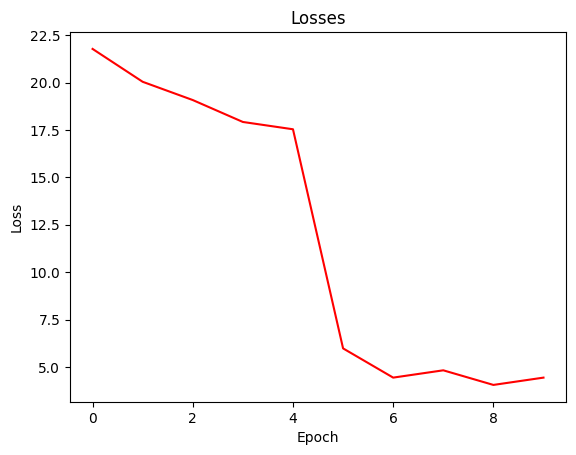

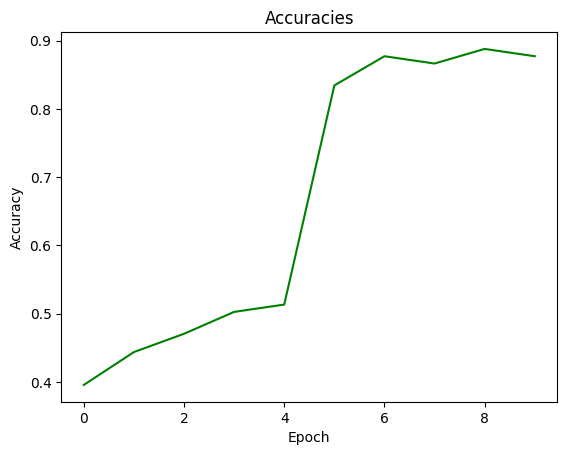

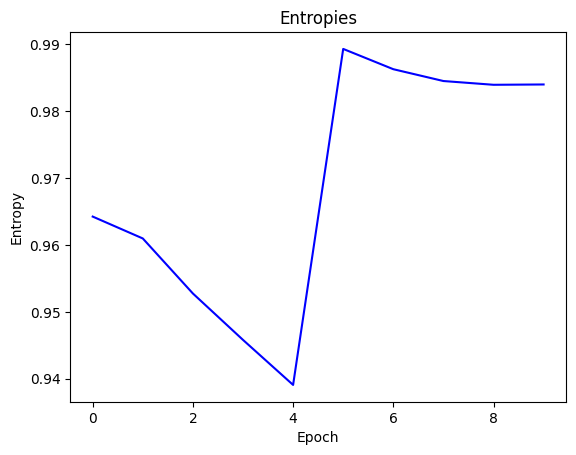

Ones predicted 97 Zeros predicted 90
Accuracy 0.8877005347593583
Average entropy 0.9836920993849803


In [34]:
# ------------------------------------------------------------------------------------------
# THIS SECTION WE DO THE TUNING FOR WHAT WE KNOW WE WANT TO BE CHANGING!
# ------------------------------------------------------------------------------------------

q = 5  # Number of qubits = Dimensionality of data = round up to even number = num qubits
c = 1
circ = QuantumCircuit(q, c)
circ.h(0)
layer_style = "Dual"
train_var_0 = init_random_variables(q // 2, layer_style)
train_var_1 = init_random_variables(q // 2, layer_style)
train_var_2 = init_random_variables(q // 2, layer_style)

tracked_d_loss = []
tracked_d_loss1 = []
tracked_d_loss2 = []
gradients = []
learning_rate = 0.01
train_iter = 5
corr = 0
wrong = 0
loss_d_to_real = 0

losses = []
accuracies = []
entropies_all = []

print('Starting Training')
print('-' * 20)
print("train_var_0 training")
for epoch in range(train_iter):
    start = time.time()
    loss = [0, 0]
    par_shift = 0.5 * np.pi / ((1 + epoch) ** 0.5)
    for index, point in enumerate(pca_data_rot3):
        for key, value in train_var_0.items():
            if str(q // 2 + 1) in key:
                break
            for key_value in range(len(value)):
                forward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_0, point, key, key_value, diff=True, fwd_diff=True)))
                backward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_0, point, key, key_value, diff=True, fwd_diff=False)))
                df = 0.5 * (forward_diff - backward_diff)
                train_var_0[key][key_value] -= df * learning_rate

    # Calculate accuracy after training
    pca_data = []
    [pca_data.append(x) for x in pca_data_rot3]
    [pca_data.append(x) for x in pca_data_rot6]
    labels = []
    [labels.append(0) for _ in range(len(pca_data_rot3))]
    [labels.append(1) for _ in range(len(pca_data_rot6))]
    
    loss = 0
    correct = 0; 
    wrong = 0;
    preds = []
    reals = []
    p0_vals = []
    p1_vals = []

    for index, x in enumerate(pca_data):
        p0 = get_probabilities(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
        p1 = get_probabilities(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
        tp = p0 + p1
        p0 = p0 / tp
        p1 = p1 / tp
        probs = np.array([p0, p1])
        p0_vals.append(p0)
        p1_vals.append(p1)
        
        if np.argmax(probs) == 1:
            preds.append(1)
        else:
            preds.append(0)

        reals.append(labels[index])
        if np.argmax(probs) == labels[index]:
            correct += 1
        else:
            wrong += 1

    print('Time for Epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    
    entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
    avg_ent1 = np.mean(entropies)
    entropies_all.append(avg_ent1)
    print('Entropy:', avg_ent1)

    loss = log_loss(reals, preds)
    losses.append(loss)
    print('Loss', loss)
    
    accuracy = correct / (correct + wrong)
    accuracies.append(accuracy)
    print('Accuracy', accuracy)
    
    print("-" * 20)
    save_variables(train_var_0, epoch, 3)

for epoch in range(train_iter):
    start = time.time()
    loss = [0, 0]
    par_shift = 0.5 * np.pi / ((1 + epoch) ** 0.5)
    for index, point in enumerate(pca_data_rot6):
        for key, value in train_var_1.items():
            if str(q // 2 + 1) in key:
                break
            for key_value in range(len(value)):
                forward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_1, point, key, key_value, diff=True, fwd_diff=True)))
                backward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_1, point, key, key_value, diff=True, fwd_diff=False)))
                df = 0.5 * (forward_diff - backward_diff)
                train_var_1[key][key_value] -= df * learning_rate

      # Calculate accuracy after training
    pca_data = []
    [pca_data.append(x) for x in pca_data_rot3]
    [pca_data.append(x) for x in pca_data_rot6]
    labels = []
    [labels.append(0) for _ in range(len(pca_data_rot3))]
    [labels.append(1) for _ in range(len(pca_data_rot6))]
    
    loss = 0
    correct = 0; 
    wrong = 0;
    preds = []
    reals = []
    p0_vals = []
    p1_vals = []

    for index, x in enumerate(pca_data):
        p0 = get_probabilities(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
        p1 = get_probabilities(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
        tp = p0 + p1
        p0 = p0 / tp
        p1 = p1 / tp
        probs = np.array([p0, p1])
        p0_vals.append(p0)
        p1_vals.append(p1)
        
        if np.argmax(probs) == 1:
            preds.append(1)
        else:
            preds.append(0)

        reals.append(labels[index])
        if np.argmax(probs) == labels[index]:
            correct += 1
        else:
            wrong += 1

    print('Time for Epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    
    entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
    avg_ent1 = np.mean(entropies)
    entropies_all.append(avg_ent1)
    print('Entropy:', avg_ent1)

    loss = log_loss(reals, preds)
    losses.append(loss)
    print('Loss', loss)
    
    accuracy = correct / (correct + wrong)
    accuracies.append(accuracy)
    print('Accuracy', accuracy)
    
    print("-" * 20)
    save_variables(train_var_1, epoch, 6)

#CHANGE PCA_DATA_ROT VARS HERE
pca_data = []
[pca_data.append(x) for x in pca_data_rot3]
[pca_data.append(x) for x in pca_data_rot6]
labels = []
[labels.append(0) for _ in range(len(pca_data_rot3))]
[labels.append(1) for _ in range(len(pca_data_rot6))]

correct = 0
wrong = 0
ones = []
zeros = []
layer_style = 'Dual'

ones_predicted = 0
zeros_predicted = 0

p0_vals = []
p1_vals = []

for index, x in enumerate(pca_data):
    p0 = get_probabilities(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
    p1 = get_probabilities(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
    tp = p0 + p1
    p0 = p0 / tp
    p1 = p1 / tp
    probs = np.array([p0, p1])

    if np.argmax(probs) == labels[index]:
        correct += 1
    else:
        wrong += 1

    if np.argmax(probs) == 1:
        ones_predicted += 1
    else:
        zeros_predicted += 1

    p0_vals.append(p0)
    p1_vals.append(p1)

entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
avg_ent = np.mean(entropies)

plt.plot(losses, label='Losses', color='red')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(accuracies, label='Accuracies', color='green')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(entropies_all, label='Entropies', color='blue')
plt.title('Entropies')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.show()

print("Ones predicted", ones_predicted, "Zeros predicted", zeros_predicted)
print(f"Accuracy {correct / (correct + wrong)}")
print("Average entropy", avg_ent)

Starting Training
--------------------
train_var_0 training
Time for Epoch 1 is 13.392050981521606 sec
Entropy: 0.8907953913824496
Loss 18.118200099342307
Accuracy 0.49732620320855614
--------------------
Time for Epoch 2 is 13.690845966339111 sec
Entropy: 0.88236031205568
Loss 17.925453289774833
Accuracy 0.5026737967914439
--------------------
Time for Epoch 3 is 13.437570095062256 sec
Entropy: 0.8775586930452077
Loss 17.53995967063989
Accuracy 0.5133689839572193
--------------------
Time for Epoch 4 is 13.514158725738525 sec
Entropy: 0.8809172614892699
Loss 16.961719241937477
Accuracy 0.5294117647058824
--------------------
Time for Epoch 5 is 13.532224893569946 sec
Entropy: 0.8761924976571198
Loss 16.768972432370006
Accuracy 0.5347593582887701
--------------------
Time for Epoch 1 is 13.697464942932129 sec
Entropy: 0.9165274020641259
Loss 14.841504336695294
Accuracy 0.5882352941176471
--------------------
Time for Epoch 2 is 13.504374980926514 sec
Entropy: 0.9324369049561241
Loss 6.

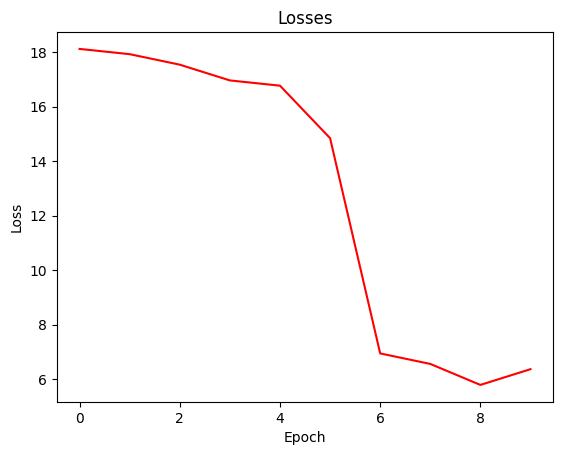

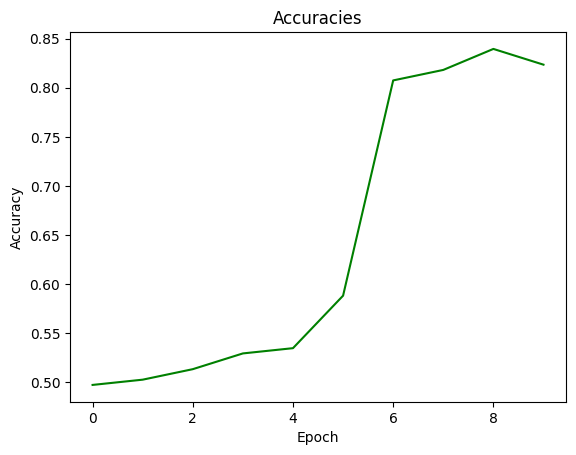

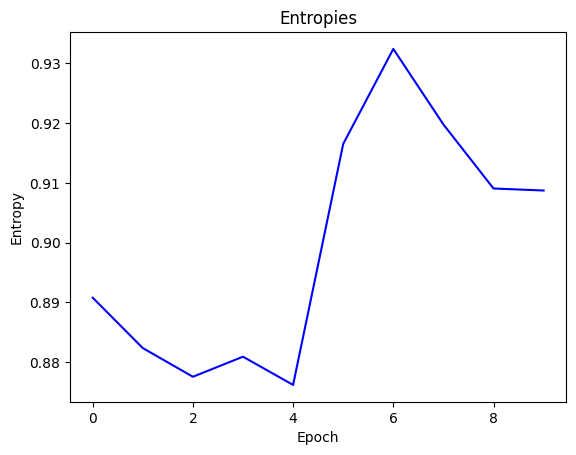

Ones predicted 71 Zeros predicted 116
Accuracy 0.8342245989304813
Average entropy 0.9043737266098704


In [35]:
# ------------------------------------------------------------------------------------------
# THIS SECTION WE DO THE TUNING FOR WHAT WE KNOW WE WANT TO BE CHANGING!
# ------------------------------------------------------------------------------------------

q = 5  # Number of qubits = Dimensionality of data = round up to even number = num qubits
c = 1
circ = QuantumCircuit(q, c)
circ.h(0)
layer_style = "Dual"
train_var_0 = init_random_variables(q // 2, layer_style)
train_var_1 = init_random_variables(q // 2, layer_style)
train_var_2 = init_random_variables(q // 2, layer_style)

tracked_d_loss = []
tracked_d_loss1 = []
tracked_d_loss2 = []
gradients = []
learning_rate = 0.01
train_iter = 5
corr = 0
wrong = 0
loss_d_to_real = 0

losses = []
accuracies = []
entropies_all = []

print('Starting Training')
print('-' * 20)
print("train_var_0 training")
for epoch in range(train_iter):
    start = time.time()
    loss = [0, 0]
    par_shift = 0.5 * np.pi / ((1 + epoch) ** 0.5)
    for index, point in enumerate(pca_data_rot3):
        for key, value in train_var_0.items():
            if str(q // 2 + 1) in key:
                break
            for key_value in range(len(value)):
                forward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_0, point, key, key_value, diff=True, fwd_diff=True)))
                backward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_0, point, key, key_value, diff=True, fwd_diff=False)))
                df = 0.5 * (forward_diff - backward_diff)
                train_var_0[key][key_value] -= df * learning_rate

    # Calculate accuracy after training
    pca_data = []
    [pca_data.append(x) for x in pca_data_rot3]
    [pca_data.append(x) for x in pca_data_rot6]
    labels = []
    [labels.append(0) for _ in range(len(pca_data_rot3))]
    [labels.append(1) for _ in range(len(pca_data_rot6))]
    
    loss = 0
    correct = 0; 
    wrong = 0;
    preds = []
    reals = []
    p0_vals = []
    p1_vals = []

    for index, x in enumerate(pca_data):
        p0 = get_probabilities(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
        p1 = get_probabilities(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
        tp = p0 + p1
        p0 = p0 / tp
        p1 = p1 / tp
        probs = np.array([p0, p1])
        p0_vals.append(p0)
        p1_vals.append(p1)
        
        if np.argmax(probs) == 1:
            preds.append(1)
        else:
            preds.append(0)

        reals.append(labels[index])
        if np.argmax(probs) == labels[index]:
            correct += 1
        else:
            wrong += 1

    print('Time for Epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    
    entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
    avg_ent1 = np.mean(entropies)
    entropies_all.append(avg_ent1)
    print('Entropy:', avg_ent1)

    loss = log_loss(reals, preds)
    losses.append(loss)
    print('Loss', loss)
    
    accuracy = correct / (correct + wrong)
    accuracies.append(accuracy)
    print('Accuracy', accuracy)
    
    print("-" * 20)
    save_variables(train_var_0, epoch, 3)

for epoch in range(train_iter):
    start = time.time()
    loss = [0, 0]
    par_shift = 0.5 * np.pi / ((1 + epoch) ** 0.5)
    for index, point in enumerate(pca_data_rot6):
        for key, value in train_var_1.items():
            if str(q // 2 + 1) in key:
                break
            for key_value in range(len(value)):
                forward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_1, point, key, key_value, diff=True, fwd_diff=True)))
                backward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_1, point, key, key_value, diff=True, fwd_diff=False)))
                df = 0.5 * (forward_diff - backward_diff)
                train_var_1[key][key_value] -= df * learning_rate

      # Calculate accuracy after training
    pca_data = []
    [pca_data.append(x) for x in pca_data_rot3]
    [pca_data.append(x) for x in pca_data_rot6]
    labels = []
    [labels.append(0) for _ in range(len(pca_data_rot3))]
    [labels.append(1) for _ in range(len(pca_data_rot6))]
    
    loss = 0
    correct = 0; 
    wrong = 0;
    preds = []
    reals = []
    p0_vals = []
    p1_vals = []

    for index, x in enumerate(pca_data):
        p0 = get_probabilities(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
        p1 = get_probabilities(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
        tp = p0 + p1
        p0 = p0 / tp
        p1 = p1 / tp
        probs = np.array([p0, p1])
        p0_vals.append(p0)
        p1_vals.append(p1)
        
        if np.argmax(probs) == 1:
            preds.append(1)
        else:
            preds.append(0)

        reals.append(labels[index])
        if np.argmax(probs) == labels[index]:
            correct += 1
        else:
            wrong += 1

    print('Time for Epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    
    entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
    avg_ent1 = np.mean(entropies)
    entropies_all.append(avg_ent1)
    print('Entropy:', avg_ent1)

    loss = log_loss(reals, preds)
    losses.append(loss)
    print('Loss', loss)
    
    accuracy = correct / (correct + wrong)
    accuracies.append(accuracy)
    print('Accuracy', accuracy)
    
    print("-" * 20)
    save_variables(train_var_1, epoch, 6)

#CHANGE PCA_DATA_ROT VARS HERE
pca_data = []
[pca_data.append(x) for x in pca_data_rot3]
[pca_data.append(x) for x in pca_data_rot6]
labels = []
[labels.append(0) for _ in range(len(pca_data_rot3))]
[labels.append(1) for _ in range(len(pca_data_rot6))]

correct = 0
wrong = 0
ones = []
zeros = []
layer_style = 'Dual'

ones_predicted = 0
zeros_predicted = 0

p0_vals = []
p1_vals = []

for index, x in enumerate(pca_data):
    p0 = get_probabilities(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
    p1 = get_probabilities(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
    tp = p0 + p1
    p0 = p0 / tp
    p1 = p1 / tp
    probs = np.array([p0, p1])

    if np.argmax(probs) == labels[index]:
        correct += 1
    else:
        wrong += 1

    if np.argmax(probs) == 1:
        ones_predicted += 1
    else:
        zeros_predicted += 1

    p0_vals.append(p0)
    p1_vals.append(p1)

entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
avg_ent = np.mean(entropies)

plt.plot(losses, label='Losses', color='red')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(accuracies, label='Accuracies', color='green')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(entropies_all, label='Entropies', color='blue')
plt.title('Entropies')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.show()

print("Ones predicted", ones_predicted, "Zeros predicted", zeros_predicted)
print(f"Accuracy {correct / (correct + wrong)}")
print("Average entropy", avg_ent)

Starting Training
--------------------
train_var_0 training
Time for Epoch 1 is 13.546441316604614 sec
Entropy: 0.8128958937513406
Loss 9.251846859238627
Accuracy 0.7433155080213903
--------------------
Time for Epoch 2 is 13.770971298217773 sec
Entropy: 0.8229350640576576
Loss 11.757555383615752
Accuracy 0.6737967914438503
--------------------
Time for Epoch 3 is 13.54010009765625 sec
Entropy: 0.81723849881049
Loss 13.299529860155523
Accuracy 0.6310160427807486
--------------------
Time for Epoch 4 is 13.6062171459198 sec
Entropy: 0.8037826271801699
Loss 15.034251146262765
Accuracy 0.5828877005347594
--------------------
Time for Epoch 5 is 13.525188684463501 sec
Entropy: 0.7950992171217587
Loss 15.99798519410012
Accuracy 0.5561497326203209
--------------------
Time for Epoch 1 is 13.552726030349731 sec
Entropy: 0.9404855301782398
Loss 6.553391525294029
Accuracy 0.8181818181818182
--------------------
Time for Epoch 2 is 13.538673877716064 sec
Entropy: 0.9404590489664292
Loss 4.818670

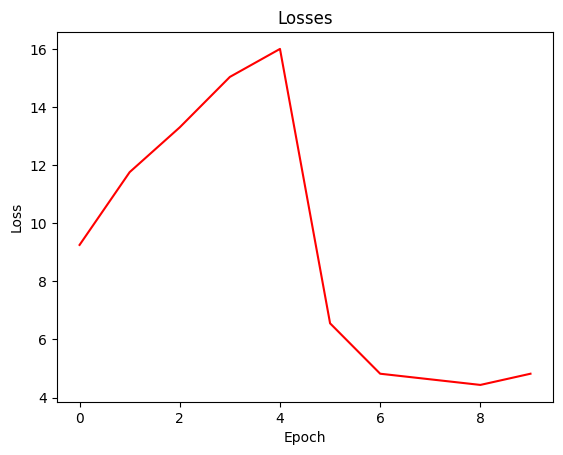

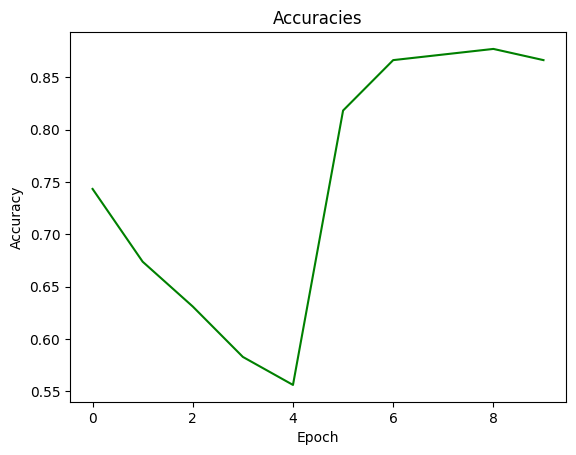

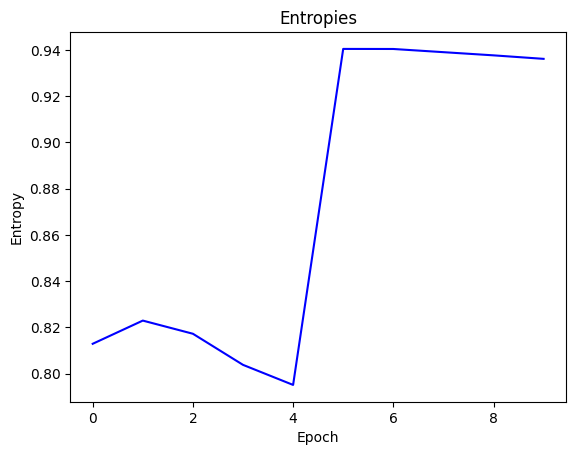

Ones predicted 104 Zeros predicted 83
Accuracy 0.8716577540106952
Average entropy 0.9364840373288883


In [36]:
# ------------------------------------------------------------------------------------------
# THIS SECTION WE DO THE TUNING FOR WHAT WE KNOW WE WANT TO BE CHANGING!
# ------------------------------------------------------------------------------------------

q = 5  # Number of qubits = Dimensionality of data = round up to even number = num qubits
c = 1
circ = QuantumCircuit(q, c)
circ.h(0)
layer_style = "Dual"
train_var_0 = init_random_variables(q // 2, layer_style)
train_var_1 = init_random_variables(q // 2, layer_style)
train_var_2 = init_random_variables(q // 2, layer_style)

tracked_d_loss = []
tracked_d_loss1 = []
tracked_d_loss2 = []
gradients = []
learning_rate = 0.01
train_iter = 5
corr = 0
wrong = 0
loss_d_to_real = 0

losses = []
accuracies = []
entropies_all = []

print('Starting Training')
print('-' * 20)
print("train_var_0 training")
for epoch in range(train_iter):
    start = time.time()
    loss = [0, 0]
    par_shift = 0.5 * np.pi / ((1 + epoch) ** 0.5)
    for index, point in enumerate(pca_data_rot3):
        for key, value in train_var_0.items():
            if str(q // 2 + 1) in key:
                break
            for key_value in range(len(value)):
                forward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_0, point, key, key_value, diff=True, fwd_diff=True)))
                backward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_0, point, key, key_value, diff=True, fwd_diff=False)))
                df = 0.5 * (forward_diff - backward_diff)
                train_var_0[key][key_value] -= df * learning_rate

    # Calculate accuracy after training
    pca_data = []
    [pca_data.append(x) for x in pca_data_rot3]
    [pca_data.append(x) for x in pca_data_rot6]
    labels = []
    [labels.append(0) for _ in range(len(pca_data_rot3))]
    [labels.append(1) for _ in range(len(pca_data_rot6))]
    
    loss = 0
    correct = 0; 
    wrong = 0;
    preds = []
    reals = []
    p0_vals = []
    p1_vals = []

    for index, x in enumerate(pca_data):
        p0 = get_probabilities(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
        p1 = get_probabilities(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
        tp = p0 + p1
        p0 = p0 / tp
        p1 = p1 / tp
        probs = np.array([p0, p1])
        p0_vals.append(p0)
        p1_vals.append(p1)
        
        if np.argmax(probs) == 1:
            preds.append(1)
        else:
            preds.append(0)

        reals.append(labels[index])
        if np.argmax(probs) == labels[index]:
            correct += 1
        else:
            wrong += 1

    print('Time for Epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    
    entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
    avg_ent1 = np.mean(entropies)
    entropies_all.append(avg_ent1)
    print('Entropy:', avg_ent1)

    loss = log_loss(reals, preds)
    losses.append(loss)
    print('Loss', loss)
    
    accuracy = correct / (correct + wrong)
    accuracies.append(accuracy)
    print('Accuracy', accuracy)
    
    print("-" * 20)
    save_variables(train_var_0, epoch, 3)

for epoch in range(train_iter):
    start = time.time()
    loss = [0, 0]
    par_shift = 0.5 * np.pi / ((1 + epoch) ** 0.5)
    for index, point in enumerate(pca_data_rot6):
        for key, value in train_var_1.items():
            if str(q // 2 + 1) in key:
                break
            for key_value in range(len(value)):
                forward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_1, point, key, key_value, diff=True, fwd_diff=True)))
                backward_diff = -np.log(get_probabilities(
                    disc_real_training_circuit(train_var_1, point, key, key_value, diff=True, fwd_diff=False)))
                df = 0.5 * (forward_diff - backward_diff)
                train_var_1[key][key_value] -= df * learning_rate

      # Calculate accuracy after training
    pca_data = []
    [pca_data.append(x) for x in pca_data_rot3]
    [pca_data.append(x) for x in pca_data_rot6]
    labels = []
    [labels.append(0) for _ in range(len(pca_data_rot3))]
    [labels.append(1) for _ in range(len(pca_data_rot6))]
    
    loss = 0
    correct = 0; 
    wrong = 0;
    preds = []
    reals = []
    p0_vals = []
    p1_vals = []

    for index, x in enumerate(pca_data):
        p0 = get_probabilities(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
        p1 = get_probabilities(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
        tp = p0 + p1
        p0 = p0 / tp
        p1 = p1 / tp
        probs = np.array([p0, p1])
        p0_vals.append(p0)
        p1_vals.append(p1)
        
        if np.argmax(probs) == 1:
            preds.append(1)
        else:
            preds.append(0)

        reals.append(labels[index])
        if np.argmax(probs) == labels[index]:
            correct += 1
        else:
            wrong += 1

    print('Time for Epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    
    entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
    avg_ent1 = np.mean(entropies)
    entropies_all.append(avg_ent1)
    print('Entropy:', avg_ent1)

    loss = log_loss(reals, preds)
    losses.append(loss)
    print('Loss', loss)
    
    accuracy = correct / (correct + wrong)
    accuracies.append(accuracy)
    print('Accuracy', accuracy)
    
    print("-" * 20)
    save_variables(train_var_1, epoch, 6)

#CHANGE PCA_DATA_ROT VARS HERE
pca_data = []
[pca_data.append(x) for x in pca_data_rot3]
[pca_data.append(x) for x in pca_data_rot6]
labels = []
[labels.append(0) for _ in range(len(pca_data_rot3))]
[labels.append(1) for _ in range(len(pca_data_rot6))]

correct = 0
wrong = 0
ones = []
zeros = []
layer_style = 'Dual'

ones_predicted = 0
zeros_predicted = 0

p0_vals = []
p1_vals = []

for index, x in enumerate(pca_data):
    p0 = get_probabilities(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
    p1 = get_probabilities(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
    tp = p0 + p1
    p0 = p0 / tp
    p1 = p1 / tp
    probs = np.array([p0, p1])

    if np.argmax(probs) == labels[index]:
        correct += 1
    else:
        wrong += 1

    if np.argmax(probs) == 1:
        ones_predicted += 1
    else:
        zeros_predicted += 1

    p0_vals.append(p0)
    p1_vals.append(p1)

entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
avg_ent = np.mean(entropies)

plt.plot(losses, label='Losses', color='red')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(accuracies, label='Accuracies', color='green')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(entropies_all, label='Entropies', color='blue')
plt.title('Entropies')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.show()

print("Ones predicted", ones_predicted, "Zeros predicted", zeros_predicted)
print(f"Accuracy {correct / (correct + wrong)}")
print("Average entropy", avg_ent)

### Circuit Example

In [38]:
disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False).draw()

┌───┐                                                        ┌───┐┌─┐
q_0: ────┤ H ├───────────────────────────────────────────────────■──■─┤ H ├┤M├
     ┌───┴───┴────┐┌─────────────┐┌───────────────┐              │  │ └───┘└╥┘
q_1: ┤ Ry(4.4491) ├┤ Rz(0.88689) ├┤0              ├─■────────────X──┼───────╫─
     ├───────────┬┘└┬────────────┤│  Ryy(0.77632) │ │ZZ(4.4481)  │  │       ║ 
q_2: ┤ Ry(2.023) ├──┤ Rz(3.8427) ├┤1              ├─■────────────┼──X───────╫─
     └┬──────────┤  └────────────┘└───────────────┘              │  │       ║ 
q_3: ─┤0         ├───────────────────────────────────────────────X──┼───────╫─
      │  Unitary │                                                  │       ║ 
q_4: ─┤1         ├──────────────────────────────────────────────────X───────╫─
      └──────────┘                                                          ║ 
c: 1/═══════════════════════════════════════════════════════════════════════╩═
                                                                            0